## Notebook for exploratory analysis of _Cai Y et al 2020_ and _Cai Y et al 2022_ healthy PBMC scRNA-Seq data using `scVI`

**Obecjtive**: Basic scVI analysis for healthy PBMC scRNA-seq data

- **Developed by**: Carlos Talavera-López Ph.D

- **Modified by**: Mairi McClean
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- original - v221101; modified v230314

### Load required modules

In [1]:
import sys
import scvi
import torch
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random


from umap import UMAP
import warnings; warnings.simplefilter('ignore')

Global seed set to 0
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/mairi.mcclean/mambaforge/envs/scvi_local/lib/python3.10/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [2]:
# Should this be put on the server?
save_path = "/Volumes/Lacie/data_lake/Mairi_example/notebook_output/paths/"

In [3]:
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [4]:
torch.cuda.is_available()

False

In [5]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.2.0
absl                NA
anyio               NA
appnope             0.1.3
asttokens           NA
attr                22.2.0
babel               2.12.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  2.1.1
chex                0.1.6
colorama            0.4.6
comm                0.1.2
contextlib2         NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
defusedxml          0.7.1
docrep              0.3.2
executing           1.2.0
fastjsonschema      NA
flax                0.5.0
fsspec              2023.3.0
h5py                3.8.0
hypergeom_ufunc     NA
idna                3.4
igraph              0.10.4
invgauss_ufunc      NA
ipykernel           6.21.2
ipython_genutils    0.2.0
ipywidgets          8.0.4
jax        

### Read in datasets

- Read in _Cai Y et al 2020_

In [6]:
# caiy2020 = sc.read_h5ad('/lustre/groups/talaveralopez/datasets/tuberculosis/rna-seq/mairi_data_lake/processed_files/abridged_qc/human/Cai2020_scRNA_PBMC_mm230306_qcd.h5ad')
# caiy2020

caiy2020 = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/processed_files/abridged_qc/human/Cai2020_scRNA_PBMC_mm230315_qcd.h5ad')
caiy2020

AnnData object with n_obs × n_vars = 73146 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors'
    layers: 'counts', 'sqrt_norm'

- Read in _Cai Y et al 2022_

In [7]:
# caiy2022 = sc.read_h5ad('/lustre/groups/talaveralopez/datasets/tuberculosis/rna-seq/mairi_data_lake/processed_files/abridged_qc/human/Cai2022_scRNA_PBMC_mm230314_qcd.h5ad')
# caiy2022.obs['status'] = 'active_TB'
# caiy2022

caiy2022 = sc.read_h5ad('/Volumes/Lacie/data_lake/Mairi_example/processed_files/abridged_qc/human/Cai2022_scRNA_PBMC_mm230315_qcd.h5ad')
caiy2022.obs['status'] = 'active_TB'
caiy2022

AnnData object with n_obs × n_vars = 25417 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'status'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors', 'sample_colors'
    layers: 'counts', 'sqrt_norm'

### Merge datasets

In [8]:
caiy_tb = caiy2020.concatenate(caiy2022, batch_key = 'dataset', batch_categories = ['caiy2020', 'caiy2022'], join = 'inner')
caiy_tb

AnnData object with n_obs × n_vars = 98563 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'age', 'gender', 'status', 'data_type', 'centre', 'version', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets', 'object', 'protocol', 'dataset'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts-caiy2020', 'mean_counts-caiy2020', 'pct_dropout_by_counts-caiy2020', 'total_counts-caiy2020', 'n_cells_by_counts-caiy2022', 'mean_counts-caiy2022', 'pct_dropout_by_counts-caiy2022', 'total_counts-caiy2022'
    layers: 'counts', 'sqrt_norm'

### Check that anndata object only contains PBMC scRNA from healthy donors

In [9]:
caiy_tb.obs

study    individual  \
barcode                                                                      
AAACCTGAGAACAATC-acTB3-caiy2020                    CaiY_2021  SAMN14048025   
AAACCTGAGAAGGTGA-acTB3-caiy2020                    CaiY_2021  SAMN14048025   
AAACCTGAGATCTGCT-acTB3-caiy2020                    CaiY_2021  SAMN14048025   
AAACCTGAGCACAGGT-acTB3-caiy2020                    CaiY_2021  SAMN14048025   
AAACCTGAGCGTGAAC-acTB3-caiy2020                    CaiY_2021  SAMN14048025   
...                                                      ...           ...   
TTTGTCAGTCCATCCT-HRS100513-pbmc_scRNAseq-caiy2022  CaiY_2022     HRI068293   
TTTGTCAGTGCTGTAT-HRS100513-pbmc_scRNAseq-caiy2022  CaiY_2022     HRI068293   
TTTGTCAGTGTGGCTC-HRS100513-pbmc_scRNAseq-caiy2022  CaiY_2022     HRI068293   
TTTGTCATCGTTTATC-HRS100513-pbmc_scRNAseq-caiy2022  CaiY_2022     HRI068293   
TTTGTCATCTTACCTA-HRS100513-pbmc_scRNAseq-caiy2022  CaiY_2022     HRI068293   

                                                      sample tissue  \
barcode                                                               
AAACCTGAGAACAATC-acTB3-caiy2020                    PBMC_TB_3   PBMC   
AAACCTGAGAAGGTGA-acTB3-caiy2020                    PBMC_TB_3   PBMC   
AAACCTGAGATCTGCT-acTB3-caiy2020                    PBMC_TB_3   PBMC   
AAACCTGAGCACAGGT-acTB3-caiy2020                    PBMC_TB_3   PBMC   
AAACCTGAGCGTGAAC-acTB3-caiy2020                    PBMC_TB_3   PBMC   
...                                                      ...    ...   
TTTGTCAGTCCATCCT-HRS100513-pbmc_scRNAseq-caiy2022  HRS100513   PBMC   
TTTGTCAGTGCTGTAT-HRS100513-pbmc_scRNAseq-caiy2022  HRS100513   PBMC   
TTTGTCAGTGTGGCTC-HRS100513-pbmc_scRNAseq-caiy2022  HRS100513   PBMC   
TTTGTCATCGTTTATC-HRS100513-pbmc_scRNAseq-caiy2022  HRS100513   PBMC   
TTTGTCATCTTACCTA-HRS100513-pbmc_scRNAseq-caiy2022  HRS100513   PBMC   

                                                          donor  age gender  \
barcode                                                                       
AAACCTGAGAACAATC-acTB3-caiy2020                    SAMN14048025   34   male   
AAACCTGAGAAGGTGA-acTB3-caiy2020                    SAMN14048025   34   male   
AAACCTGAGATCTGCT-acTB3-caiy2020                    SAMN14048025   34   male   
AAACCTGAGCACAGGT-acTB3-caiy2020                    SAMN14048025   34   male   
AAACCTGAGCGTGAAC-acTB3-caiy2020                    SAMN14048025   34   male   
...                                                         ...  ...    ...   
TTTGTCAGTCCATCCT-HRS100513-pbmc_scRNAseq-caiy2022            P4  NaN    NaN   
TTTGTCAGTGCTGTAT-HRS100513-pbmc_scRNAseq-caiy2022            P4  NaN    NaN   
TTTGTCAGTGTGGCTC-HRS100513-pbmc_scRNAseq-caiy2022            P4  NaN    NaN   
TTTGTCATCGTTTATC-HRS100513-pbmc_scRNAseq-caiy2022            P4  NaN    NaN   
TTTGTCATCTTACCTA-HRS100513-pbmc_scRNAseq-caiy2022            P4  NaN    NaN   

                                                      status data_type  \
barcode                                                                  
AAACCTGAGAACAATC-acTB3-caiy2020                    active_TB  scRNAseq   
AAACCTGAGAAGGTGA-acTB3-caiy2020                    active_TB  scRNAseq   
AAACCTGAGATCTGCT-acTB3-caiy2020                    active_TB  scRNAseq   
AAACCTGAGCACAGGT-acTB3-caiy2020                    active_TB  scRNAseq   
AAACCTGAGCGTGAAC-acTB3-caiy2020                    active_TB  scRNAseq   
...                                                      ...       ...   
TTTGTCAGTCCATCCT-HRS100513-pbmc_scRNAseq-caiy2022  active_TB  scRNAseq   
TTTGTCAGTGCTGTAT-HRS100513-pbmc_scRNAseq-caiy2022  active_TB  scRNAseq   
TTTGTCAGTGTGGCTC-HRS100513-pbmc_scRNAseq-caiy2022  active_TB  scRNAseq   
TTTGTCATCGTTTATC-HRS100513-pbmc_scRNAseq-caiy2022  active_TB  scRNAseq   
TTTGTCATCTTACCTA-HRS100513-pbmc_scRNAseq-caiy2022  active_TB  scRNAseq   

                                                                centre  ...  \
barcode                                       

In [10]:
caiy_tb.obs['data_type'].value_counts()

scRNAseq    98563
Name: data_type, dtype: int64

In [11]:
caiy_tb.obs['tissue'].value_counts()

PBMC    98563
Name: tissue, dtype: int64

In [12]:
caiy_tb.obs['status'].value_counts()

active_TB    58521
Healthy      22049
latent_TB    17993
Name: status, dtype: int64

In [13]:
caiy_healthy = caiy_tb[~caiy_tb.obs['status'].isin(['active_TB', 'latent_TB']),:]

In [14]:
caiy_healthy.obs['status'].value_counts()

Healthy    22049
Name: status, dtype: int64

### Calculate HVGs

In [15]:
adata = caiy_healthy.copy()
adata.layers['counts'] = adata.X.copy()

In [16]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 8000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


### Data integration with `scVI`

In [17]:
# We need to 'register' the data as an anndata object first before introducing to model

scvi.model.SCVI.setup_anndata(
    adata,
    layer = "counts",
    categorical_covariate_keys = ["sample"],
    continuous_covariate_keys = ["n_genes", "n_counts"]
)




In [18]:
model = scvi.model.SCVI(adata, n_layers = 3, n_latent = 25, gene_likelihood = "nb", dispersion = 'gene-batch')
model

# Why have all of the parameters not been included?
# What is the "dispersion" argument referring to specifically?


SCVI Model with the following params: 
n_hidden: 128, n_latent: 25, n_layers: 3, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: nb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [19]:
scvi.model.SCVI.view_anndata_setup(model)

Anndata setup with scvi-tools version 0.20.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['sample'],
│   'continuous_covariate_keys': ['n_genes', 'n_counts']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 22049 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 8000  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ PBMC_HC_1  │          0          │
│                     │ PBMC_HC_2  │          1          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

  extra_continuous_covs  
     State Registry      
┏━━━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['n_genes']  │
│ adata.obs['n_counts'] │
└───────────────────────┘

In [20]:
model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 363/363: 100%|██████████| 363/363 [1:15:19<00:00, 11.60s/it, loss=2.2e+03, v_num=1]    

`Trainer.fit` stopped: `max_epochs=363` reached.


Epoch 363/363: 100%|██████████| 363/363 [1:15:19<00:00, 12.45s/it, loss=2.2e+03, v_num=1]


In [21]:
model.save("/Volumes/LaCie/data_lake/Mairi_example/INBOX/models/mm230420_Cai_healthy_PBMC_scRNA_scvi_model/")

#### Model outputs

In [22]:
# making the obsm part of the anndata object a new object, titled "latent", which contains the latent representations of each cell.
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

#### Visualisation with batch correction

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


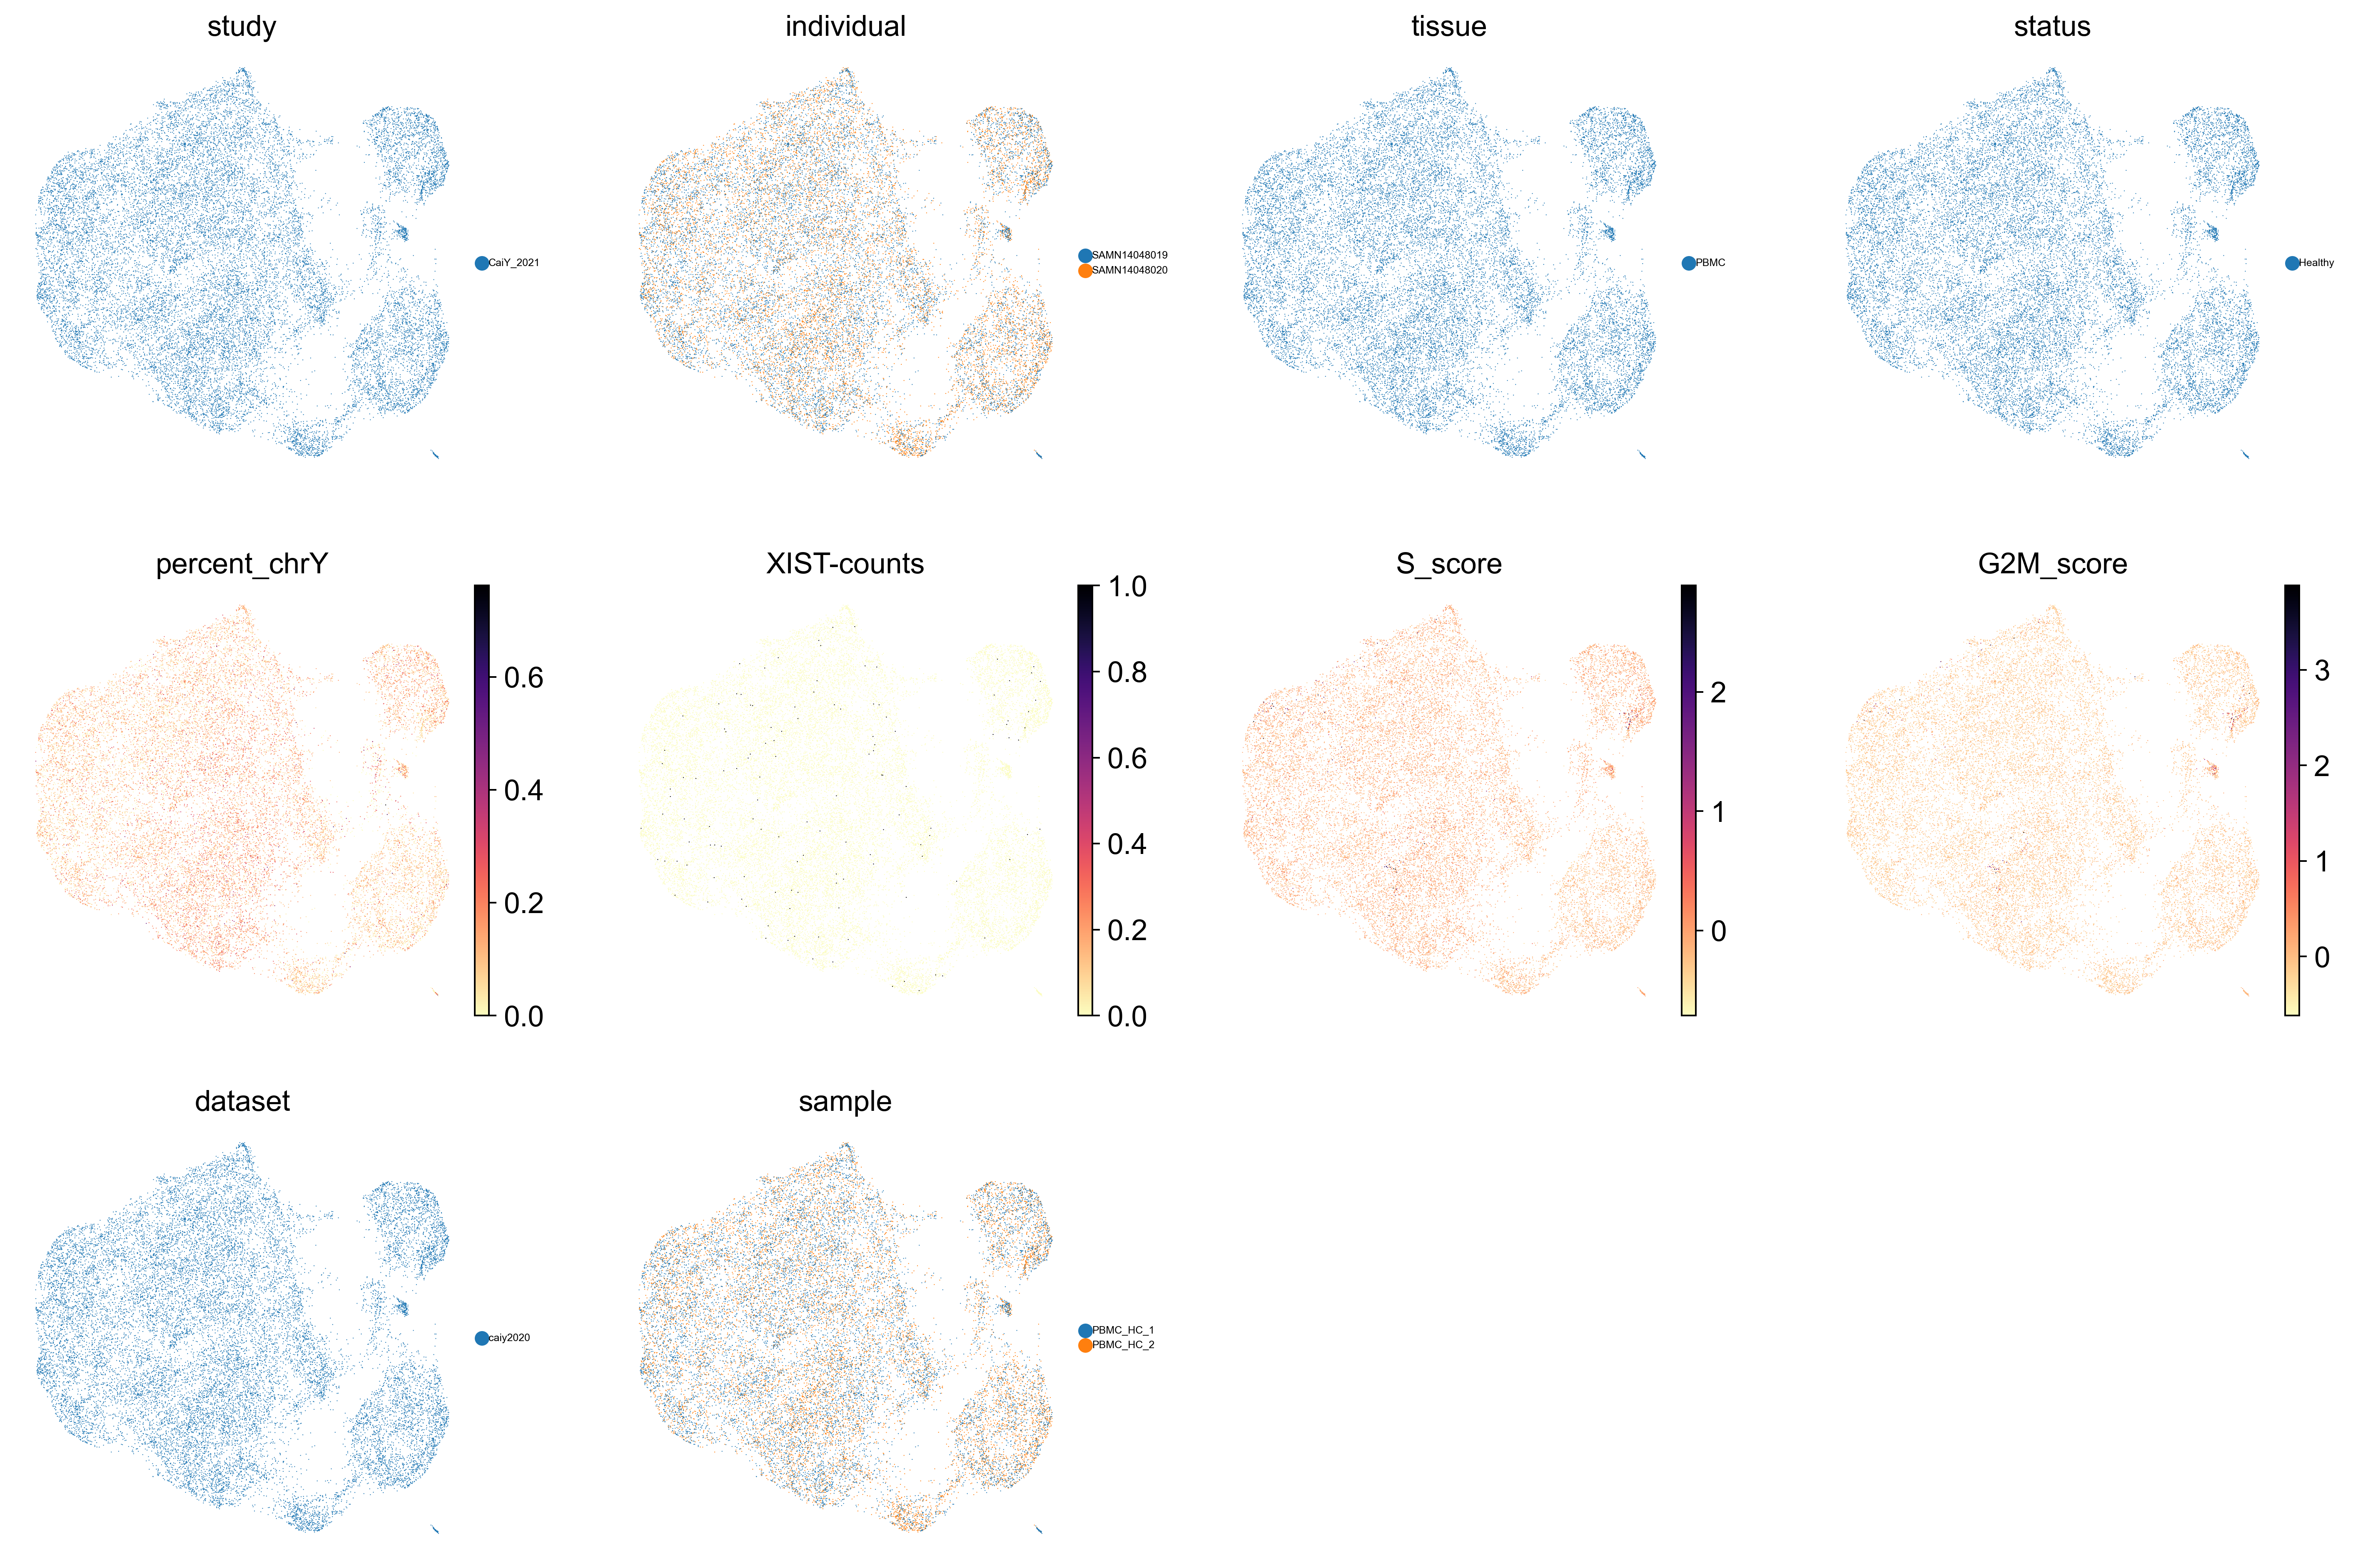

In [23]:
# 'minkowski' here refers to Minkowski distance (generalization of both the Euclidean distance and the Manhattan distance.)

# PCA was not run to use scVI latent space for UMAP vis
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 6, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['study', 'individual', 'tissue', 'status', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'dataset', 'sample'], size = 0.8, legend_fontsize = 5, ncols = 4)

In [24]:
# sc.pl.umap(adata, frameon = False, color = ['CD74', 'CD3E', 'CD40LG', 'CD8A', 'NKG7', 'CLEC9A', 'CD14', 'FCGR3A'], size = 1, legend_fontsize = 5, legend_loc = 'on data', ncols = 4)

#### Export data for sccaf

In [25]:
adata.write('/Volumes/LaCie/data_lake/Mairi_example/processed_files/scvi/pre_sccaf/Cai_healthy_scRNA_PBMC_mm230420_pre_sccaf_adata.h5ad')
caiy_healthy.write('/Volumes/LaCie/data_lake/Mairi_example/processed_files/scvi/pre_sccaf/Cai_healthy_scRNA_PBMC_mm230420_pre_sccaf_caiy_healthy.h5ad')


# Why are two objects required?